<a href="https://colab.research.google.com/github/nicholasproietti/LGM/blob/main/Kepler_Light_Curve_Reader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%matplotlib notebook
from astropy.io import fits
from astropy.table import Table 
import matplotlib.pyplot as plt

In [ ]:
!pip install astroquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 4.2 MB/s 
     |████████████████████████████████| 832 kB 43.9 MB/s 
     |████████████████████████████████| 48 kB 5.2 MB/s 
     |████████████████████████████████| 4.0 MB 40.6 MB/s 


In [ ]:
# Import libraries from astroquery

from astroquery.mast import Mast
from astroquery.mast import Observations

In [ ]:
# Search MAST portal for data of a particular Kepler target (target name, spacecraft)

keplerObs = Observations.query_criteria(target_name='kplr011446443', obs_collection='Kepler')
keplerProds = Observations.get_product_list(keplerObs[1])
yourProd = Observations.filter_products(keplerProds, extension='kplr011446443-2009131110544_slc.fits', 
                                        mrp_only=False)
yourProd



obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str6,str6,str10,str36,str60,str1,str110,str7,str28,str8,str1,str6,str1,str7,str44,int64,str6,str6,int64
601031,Kepler,timeseries,kplr011446443_sc_Q113313330333033302,Lightcurve Short Cadence (CSC) - Q0,C,mast:KEPLER/url/missions/kepler/lightcurves/0114/011446443/kplr011446443-2009131110544_slc.fits,SCIENCE,Minimum Recommended Products,SLC,--,Kepler,--,EX_STKS,kplr011446443-2009131110544_slc.fits,1457280,601031,PUBLIC,2


In [ ]:
# Download the data file

Observations.download_products(yourProd, mrp_only = False, cache = False) 

Local Path,Status,Message,URL
str95,str8,object,object
./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009131110544_slc.fits,COMPLETE,None,None


In [ ]:
# See some information about the FITS Header Data Units:

filename = "./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009131110544_slc.fits"
fits.info(filename)



Filename: ./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009131110544_slc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   14280R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (8, 9)   int32   


In [ ]:
# Opens the FITS file, writes the first HDU extension into header1, and then closes the file

with fits.open(filename) as hdulist: 
    header1 = hdulist[1].header
  
print(repr(header1[0:24])) #repr() prints the info into neat columns

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                14280 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [ ]:
# View a table of the data from the Binary Table extension. This is where we can find the flux and time columns to be plotted later.

with fits.open(filename) as hdulist:
    binaryext = hdulist[1].data

binarytable = Table(binaryext)
binarytable[1:5]

TIME,TIMECORR,CADENCENO,SAP_FLUX,SAP_FLUX_ERR,SAP_BKG,SAP_BKG_ERR,PDCSAP_FLUX,PDCSAP_FLUX_ERR,SAP_QUALITY,PSF_CENTR1,PSF_CENTR1_ERR,PSF_CENTR2,PSF_CENTR2_ERR,MOM_CENTR1,MOM_CENTR1_ERR,MOM_CENTR2,MOM_CENTR2_ERR,POS_CORR1,POS_CORR2
float64,float32,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
120.52992386784899,0.00096672785,5501,401288.16,91.51187,2598.1086,0.5752603,406100.9,127.528824,0,nan,nan,nan,nan,621.2181187542091,0.0002101067,848.8972881655714,0.00029125414,0.0002031729,-0.0025746305
120.53060508973431,0.00096674974,5502,401425.53,91.53448,2598.0261,0.57525027,406242.22,125.212105,0,nan,nan,nan,nan,621.2190207168474,0.00021018942,848.8935790650855,0.0002912894,0.00021144762,-0.0025837936
120.53128621167707,0.0009667717,5503,401172.0,91.517265,2597.9438,0.5752402,405984.03,123.31339,0,nan,nan,nan,nan,621.2179228162092,0.00021032244,848.894852260174,0.0002914222,0.00021972114,-0.0025929555
120.53196743356966,0.00096679357,5504,401473.62,91.53064,2597.8613,0.5752302,406293.0,121.84987,0,nan,nan,nan,nan,621.2198263101714,0.00021020704,848.8961790332079,0.00029115527,0.00022799587,-0.0026021185


In [ ]:
# Convert the time to Barycentric Julian Days and read relevant LC data

with fits.open(filename, mode="readonly") as hdulist:
    # Read in the "BJDREF" which is the time offset of the time array.
    bjdrefi = hdulist[1].header['BJDREFI'] 
    bjdreff = hdulist[1].header['BJDREFF']

    # Read in the columns of data.
    times = hdulist[1].data['time'] 
    sap_fluxes = hdulist[1].data['SAP_FLUX']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

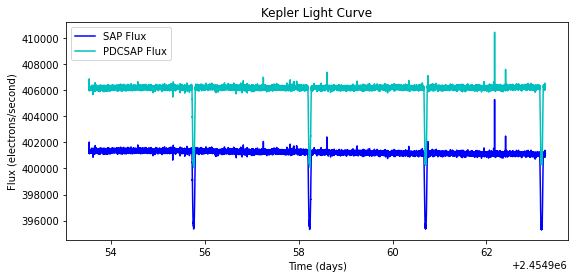

In [ ]:
# Convert the time array to full BJD by adding the offset back in.
bjds = times + bjdrefi + bjdreff 

plt.figure(figsize=(9,4))

# Plot the time, uncorrected and corrected fluxes.
plt.plot(bjds, sap_fluxes, '-b', label='SAP Flux') 
plt.plot(bjds, pdcsap_fluxes, '-c', label='PDCSAP Flux') 

plt.title('Kepler Light Curve')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Flux (electrons/second)')
plt.savefig('sample_LCs.png')